In [175]:
import numpy as np
import os, sys, random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from utils.data_utils import SAMPLING_FREQUENCY
import scipy.stats

In [120]:
def bland_altman_plot(m1, m2, sd_limit=1.96, ax=None, annotate=True, 
                        scatter_kwds=None, mean_line_kwds=None, limit_lines_kwds=None):
    """
    Construct a Tukey/Bland-Altman Mean Difference Plot.

    Tukey's Mean Difference Plot (also known as a Bland-Altman plot) is a
    graphical method to analyze the differences between two methods of
    measurement. The mean of the measures is plotted against their difference.

    For more information see
    https://en.wikipedia.org/wiki/Bland-Altman_plot

    Parameters
    ----------
    m1 : array_like
        A 1-d array.
    m2 : array_like
        A 1-d array.
    sd_limit : float
        The limit of agreements expressed in terms of the standard deviation of
        the differences. If `md` is the mean of the differences, and `sd` is
        the standard deviation of those differences, then the limits of
        agreement that will be plotted are md +/- sd_limit * sd.
        The default of 1.96 will produce 95% confidence intervals for the means
        of the differences. If sd_limit = 0, no limits will be plotted, and
        the ylimit of the plot defaults to 3 standard deviations on either
        side of the mean.
    ax : AxesSubplot
        If `ax` is None, then a figure is created. If an axis instance is
        given, the mean difference plot is drawn on the axis.
    scatter_kwds : dict
        Options to to style the scatter plot. Accepts any keywords for the
        matplotlib Axes.scatter plotting method
    mean_line_kwds : dict
        Options to to style the scatter plot. Accepts any keywords for the
        matplotlib Axes.axhline plotting method
    limit_lines_kwds : dict
        Options to to style the scatter plot. Accepts any keywords for the
        matplotlib Axes.axhline plotting method

    Returns
    -------
    Figure
        If `ax` is None, the created figure.  Otherwise the figure to which
        `ax` is connected.

    References
    ----------
    Bland JM, Altman DG (1986). "Statistical methods for assessing agreement
    between two methods of clinical measurement"

    Examples
    --------

    Load relevant libraries.

    >>> import statsmodels.api as sm
    >>> import numpy as np
    >>> import matplotlib.pyplot as plt

    Making a mean difference plot.

    >>> # Seed the random number generator.
    >>> # This ensures that the results below are reproducible.
    >>> np.random.seed(9999)
    >>> m1 = np.random.random(20)
    >>> m2 = np.random.random(20)
    >>> f, ax = plt.subplots(1, figsize = (8,5))
    >>> sm.graphics.mean_diff_plot(m1, m2, ax = ax)
    >>> plt.show()

    .. plot:: plots/graphics-mean_diff_plot.py
    """
    if ax is None:
        try:
            import matplotlib.pyplot as plt
        except:
            raise ImportError("Matplotlib is not found.")
        fig = plt.figure()
        ax = fig.add_subplot(111)
    else:
        fig = ax.figure

    if len(m1) != len(m2):
        raise ValueError('m1 does not have the same length as m2.')
    if sd_limit < 0:
        raise ValueError('sd_limit ({}) is less than 0.'.format(sd_limit))

    means = np.mean([m1, m2], axis=0)
    diffs = m1 - m2
    mean_diff = np.mean(diffs)
    std_diff = np.std(diffs, axis=0)

    scatter_kwds = scatter_kwds or {}
    if 's' not in scatter_kwds:
        scatter_kwds['s'] = 20
    mean_line_kwds = mean_line_kwds or {}
    limit_lines_kwds = limit_lines_kwds or {}
    for kwds in [mean_line_kwds, limit_lines_kwds]:
        if 'color' not in kwds:
            kwds['color'] = 'gray'
        if 'linewidth' not in kwds:
            kwds['linewidth'] = 1
    if 'linestyle' not in mean_line_kwds:
        kwds['linestyle'] = '--'
    if 'linestyle' not in limit_lines_kwds:
        kwds['linestyle'] = ':'

    ax.scatter(means, diffs, **scatter_kwds) # Plot the means against the diffs.
    ax.axhline(mean_diff, **mean_line_kwds)  # draw mean line.

    # Annotate mean line with mean difference.
    if annotate:
        ax.annotate('mean diff:\n{}'.format(np.round(mean_diff, 2)),
                    xy=(0.99, 0.5),
                    horizontalalignment='right',
                    verticalalignment='center',
                    fontsize=14,
                    xycoords='axes fraction')

    if sd_limit > 0:
        half_ylim = (1.5 * sd_limit) * std_diff
        ax.set_ylim(mean_diff - half_ylim,
                    mean_diff + half_ylim)
        limit_of_agreement = sd_limit * std_diff
        lower = mean_diff - limit_of_agreement
        upper = mean_diff + limit_of_agreement
        for j, lim in enumerate([lower, upper]):
            ax.axhline(lim, **limit_lines_kwds)
        if annotate:
            range_lim = (0.20 - (-0.20))
            low_lim = (lower - (-0.20))/(0.20 - (-0.20))
            high_lim = (upper - (-0.20))/(0.20 - (-0.20))
            ax.annotate(f'\N{MINUS SIGN}{sd_limit} SD: {lower:0.2g}',
                        xy=(0.99, low_lim-0.02*range_lim), # (0.99, 0.07),
                        horizontalalignment='right',
                        verticalalignment='top',
                        fontsize=14,
                        xycoords='axes fraction')
            ax.annotate(f'+{sd_limit} SD: {upper:0.2g}',
                        xy=(0.99, high_lim+0.02*range_lim), # (0.99, 0.92),
                        horizontalalignment='right',
                        verticalalignment='bottom',
                        fontsize=14,
                        xycoords='axes fraction')
    elif sd_limit == 0:
        half_ylim = 3 * std_diff
        ax.set_ylim(mean_diff - half_ylim,
                    mean_diff + half_ylim)

    ax.set_ylabel('Difference', fontsize=15)
    ax.set_xlabel('Means', fontsize=15)
    ax.tick_params(labelsize=13)
    fig.tight_layout()
    return fig

In [5]:
def get_metrics(df_events):
    
    # Compute the number of true positives, false negative and false positives
    num_TPs = len(df_events[(df_events["ref"].isna()==False) & (df_events["pred"].isna()==False)])
    num_FNs = len(df_events[(df_events["ref"].isna()==False) & (df_events["pred"].isna())])
    num_FPs = len(df_events[(df_events["ref"].isna()) & (df_events["pred"].isna()==False)])
    
    # Get the total number of events
    num_Ps = num_TPs + num_FNs
    
    # Compute recall and precision
    recall = num_TPs / num_Ps
    precision = num_TPs / (num_TPs + num_FPs)
    return num_TPs, num_FNs, num_FPs, recall, precision
    

In [2]:
tsv_file = "gait_events_02.tsv"
df = pd.read_csv(tsv_file, sep="\t", header=0)
df.tail()

,file_path,sub_id,cohort,gait_event,side,ref,pred
26792,/home/robbin/Datasets/Mobilise-D/rawdata/Micro...,sub-5011,PFF,FC,R,547.0,554.0
26793,/home/robbin/Datasets/Mobilise-D/rawdata/Micro...,sub-5011,PFF,FC,R,750.0,757.0
26794,/home/robbin/Datasets/Mobilise-D/rawdata/Micro...,sub-5011,PFF,FC,R,931.0,937.0
26795,/home/robbin/Datasets/Mobilise-D/rawdata/Micro...,sub-5011,PFF,FC,R,1254.0,1260.0
26796,/home/robbin/Datasets/Mobilise-D/rawdata/Micro...,sub-5011,PFF,FC,R,1489.0,1495.0


In [6]:
num_TPs, num_FNs, num_FPs, recall, precision = get_metrics(df)

In [7]:
print(f"Recall: {recall:.3f}")
print(f"Precision: {precision:.3f}")

Recall: 0.990
Precision: 0.969


In [13]:
for coh, df_coh in df.groupby(["cohort", "gait_event"]):
    num_TPs, num_FNs, num_FPs, recall, precision = get_metrics(df_coh)
    print(f"{coh[0]:>6s}, {coh[1]:>4s} | {recall:.3f} | {precision:.3f}")

   CHF,   FC | 0.998 | 0.946
   CHF,   IC | 0.993 | 0.958
  COPD,   FC | 0.984 | 0.942
  COPD,   IC | 0.975 | 0.964
    HA,   FC | 0.994 | 0.962
    HA,   IC | 0.985 | 0.974
    MS,   FC | 0.995 | 0.964
    MS,   IC | 0.993 | 0.973
    PD,   FC | 0.999 | 0.978
    PD,   IC | 0.991 | 0.984
   PFF,   FC | 0.989 | 0.973
   PFF,   IC | 0.993 | 0.991


In [17]:
time_diff = (df["pred"] - df["ref"])/SAMPLING_FREQUENCY
df["diff"] = time_diff

In [18]:
df.head()

,file_path,sub_id,cohort,gait_event,side,ref,pred,diff
0,/home/robbin/Datasets/Mobilise-D/rawdata/Micro...,sub-1011,HA,IC,L,91.0,90.0,-0.01
1,/home/robbin/Datasets/Mobilise-D/rawdata/Micro...,sub-1011,HA,IC,L,240.0,239.0,-0.01
2,/home/robbin/Datasets/Mobilise-D/rawdata/Micro...,sub-1011,HA,IC,L,363.0,364.0,0.01
3,/home/robbin/Datasets/Mobilise-D/rawdata/Micro...,sub-1011,HA,IC,L,526.0,525.0,-0.01
4,/home/robbin/Datasets/Mobilise-D/rawdata/Micro...,sub-1011,HA,IC,L,663.0,664.0,0.01


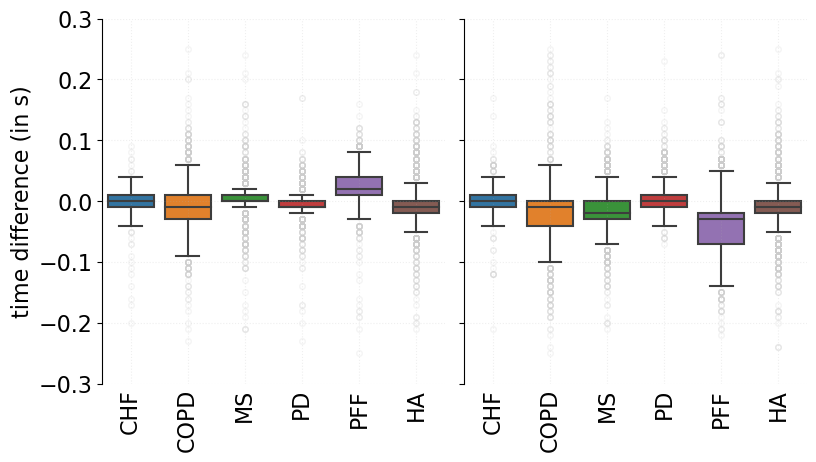

In [188]:
import enum


group_order = ["CHF", "COPD", "MS", "PD", "PFF", "HA"]
flier_props = {"marker": "o", "mfc": "None", "mec": (0.8, 0.8, 0.8), "ms": 4, "alpha": 0.2}

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(21/2.54, 12/2.54))
sns.boxplot(
    ax=axs[0],
    data=df[(df["gait_event"]=="IC")],
    y="diff",
    x="cohort",
    order=group_order,
    showfliers=True,
    flierprops=flier_props
)
sns.despine(bottom=True)

sns.boxplot(
    ax=axs[1],
    data=df[(df["gait_event"]=="FC")],
    y="diff",
    x="cohort",
    order=group_order,
    showfliers=True,
    flierprops=flier_props
)
sns.despine(bottom=True)

axs[0].set_ylabel("time difference (in s)", fontsize=16)
axs[0].set_ylim((-0.3, 0.3))
axs[1].set_ylabel("")

for i, ax in enumerate(axs):
    ax.set_yticks(np.arange(-0.3, 0.3 + 0.100, 0.100))
    ax.grid(alpha=0.2, ls=":")
    ax.set_xlabel("")
    ax.tick_params(axis="x", which="both", length=0)
    for label in ax.get_yticklabels():
        label.set_fontsize(16)
    for label in ax.get_xticklabels():
        label.set_fontsize(16)
        label.set_rotation(90)

plt.tight_layout()
plt.savefig("boxplots_gait_events_time_difference_with_outliers.png", dpi=150)
plt.show()

In [118]:
import scipy.stats

print(f"{'cohort':>8s} {'type':>4s} {'mean':>6s} [{'min':>6s}, {'max':>6s}] {'median':>6s} ({'Q1':>6s}, {'Q3':>6s})")
for crit, df_crit in df.groupby(["cohort", "gait_event"]):
    median = np.percentile(df_crit[df_crit["diff"].isna()==False]["diff"].values, 50)
    Q1 = np.percentile(df_crit[df_crit["diff"].isna()==False]["diff"].values, 25)
    Q3 = np.percentile(df_crit[df_crit["diff"].isna()==False]["diff"].values, 75)
    
    x_bar = np.mean(df_crit[df_crit["diff"].isna()==False]["diff"].values)
    z_star = np.abs(scipy.stats.norm.ppf(0.025))
    s = np.std(df_crit[df_crit["diff"].isna()==False]["diff"].values)
    n = len(df_crit[df_crit["diff"].isna()==False]["diff"].values)
    x_min = x_bar - z_star * s/np.sqrt(n)
    x_max = x_bar + z_star * s/np.sqrt(n)
    print(f"{crit[0]:>8s} {crit[1]:>4s} {x_bar:>6.3f} [{x_min:>6.3f}, {x_max:>6.3f}] {median:>6.3f} ({Q1:>6.3f}, {Q3:>6.3f})")
    

  cohort type   mean [   min,    max] median (    Q1,     Q3)
     CHF   FC  0.001 [-0.002,  0.004]  0.000 (-0.010,  0.010)
     CHF   IC -0.003 [-0.005, -0.000]  0.000 (-0.010,  0.010)
    COPD   FC -0.018 [-0.020, -0.016] -0.010 (-0.040,  0.000)
    COPD   IC -0.010 [-0.012, -0.009] -0.010 (-0.030,  0.010)
      HA   FC -0.011 [-0.012, -0.010] -0.010 (-0.020,  0.000)
      HA   IC -0.007 [-0.007, -0.006] -0.010 (-0.020,  0.000)
      MS   FC -0.018 [-0.020, -0.017] -0.020 (-0.030,  0.000)
      MS   IC  0.004 [ 0.003,  0.005]  0.000 ( 0.000,  0.010)
      PD   FC  0.005 [ 0.004,  0.006]  0.000 (-0.010,  0.010)
      PD   IC -0.006 [-0.007, -0.005] -0.010 (-0.010,  0.000)
     PFF   FC -0.041 [-0.044, -0.039] -0.030 (-0.070, -0.020)
     PFF   IC  0.023 [ 0.021,  0.024]  0.020 ( 0.010,  0.040)


In [100]:
iqr(df_crit[(df_crit["diff"].isna()==False)]["diff"])

0.02

In [104]:
import scipy.stats
scipy.stats.norm.ppf(0.025)

-1.9599639845400545

### Stride-specific parameters

In [147]:
tsv_file = "stride_params_02.tsv"
df_strides = pd.read_csv(tsv_file, sep="\t", header=0)
df_strides.tail()

,file_path,sub_id,cohort,gait_phase,side,ref,pred
36766,/home/robbin/Datasets/Mobilise-D/rawdata/Micro...,sub-5011,PFF,swing,right,0.40,0.31
36767,/home/robbin/Datasets/Mobilise-D/rawdata/Micro...,sub-5011,PFF,stride,right,1.76,1.70
36768,/home/robbin/Datasets/Mobilise-D/rawdata/Micro...,sub-5011,PFF,stance,right,2.83,2.92
36769,/home/robbin/Datasets/Mobilise-D/rawdata/Micro...,sub-5011,PFF,swing,right,0.43,0.39
36770,/home/robbin/Datasets/Mobilise-D/rawdata/Micro...,sub-5011,PFF,stride,right,3.26,3.31


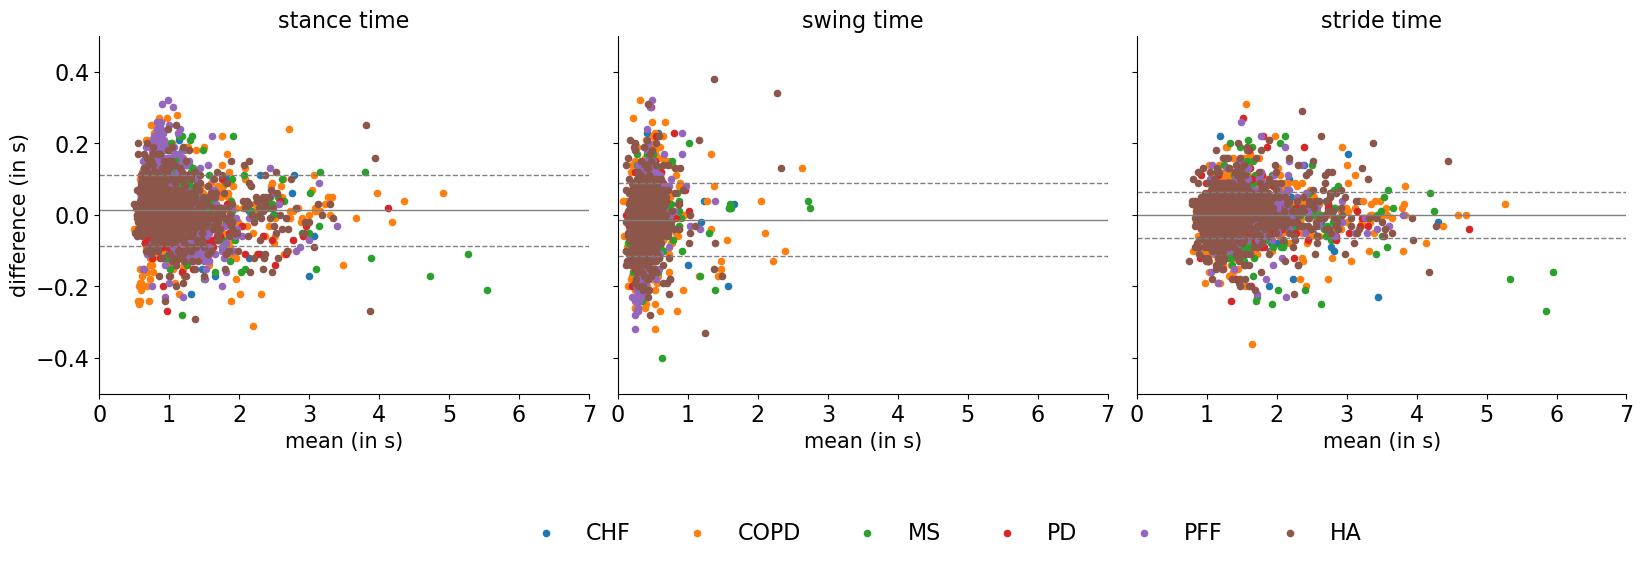

In [190]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(42/2.54, 12/2.54))
for i, gait_phase in enumerate(df_strides["gait_phase"].unique()):
    df_sel = df_strides[(df_strides["gait_phase"]==gait_phase)]
    bland_altman_plot(
        df_sel.ref,
        df_sel.pred,
        ax=axs[i],
        annotate=False,
        scatter_kwds=dict(c="w", alpha=.01)
    )
    for j, cohort in enumerate(group_order):
        df_coh = df_sel[(df_sel["cohort"]==cohort)]
        if (i < len(df_strides["gait_phase"].unique())-1) and j < len(group_order)-1:    
            bland_altman_plot(
                df_coh.ref,
                df_coh.pred,
                ax=axs[i],
                annotate=False,
                mean_line_kwds=dict(ls="None"),
                limit_lines_kwds=dict(ls="None")
            )
        else:
            bland_altman_plot(df_coh.ref, df_coh.pred, ax=axs[i], annotate=False, scatter_kwds=dict(label=cohort), mean_line_kwds=dict(ls="None"), limit_lines_kwds=dict(ls="None"))
    axs[i].set_title(f"{gait_phase} time", fontsize=16)

for i, ax in enumerate(axs):
    ax.set_xlabel("mean (in s)")
    ax.set_xlim((0.0, 7.0))
    ax.set_ylim((-0.5, 0.5))
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    if i != 0:
        ax.set_ylabel("")
    else:
        ax.set_ylabel("difference (in s)")
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontsize(16)
plt.tight_layout()
plt.legend(bbox_to_anchor=(0.5, -0.3), ncol=6, frameon=False, fontsize=16)
plt.savefig("bland_altman_stride_params.png", dpi=150, bbox_inches="tight")
plt.show()

In [185]:
alpha = 0.05  # significance level
for i, gait_phase in enumerate(df_strides["gait_phase"].unique()):
    df_sel = df_strides[(df_strides["gait_phase"]==gait_phase)]
    for j, cohort in enumerate(group_order):
        df_cohort = df_sel[(df_sel["cohort"]==cohort)]
        m1, m2 = df_cohort.ref, df_cohort.pred
        means = np.mean([m1, m2], axis=0)
        diffs = m1 - m2
        mean_diff = np.mean(diffs)
        std_diff = np.std(diffs, axis=0)
        limit_of_agreement = scipy.stats.norm.ppf(1-(alpha/2)) * std_diff
        lower_lim = mean_diff - limit_of_agreement
        upper_lim = mean_diff + limit_of_agreement
        statistic, pvalue = scipy.stats.wilcoxon(m1, m2, alternative="two-sided")
        if j > 0:
            print(f"{' '*12:>12s} {cohort:>8s} | {mean_diff:>8.2f} ({lower_lim:>6.2f}, {upper_lim:>6.2f}) {pvalue:>6.3f}")
        else:
            print(f"{gait_phase:>12s} {cohort:>8s} | {mean_diff:>8.2f} ({lower_lim:>6.2f}, {upper_lim:>6.2f}) {pvalue:>6.3f}")
    print(f"{'-'*60:s}")

      stance      CHF |    -0.00 ( -0.08,   0.07)  0.005
                 COPD |     0.01 ( -0.11,   0.13)  0.000
                   MS |     0.02 ( -0.05,   0.10)  0.000
                   PD |    -0.01 ( -0.06,   0.04)  0.000
                  PFF |     0.07 ( -0.06,   0.19)  0.000
                   HA |     0.00 ( -0.07,   0.08)  0.000
------------------------------------------------------------
       swing      CHF |     0.00 ( -0.07,   0.07)  0.030
                 COPD |    -0.01 ( -0.13,   0.11)  0.000
                   MS |    -0.02 ( -0.10,   0.05)  0.000
                   PD |     0.01 ( -0.04,   0.06)  0.000
                  PFF |    -0.07 ( -0.20,   0.07)  0.000
                   HA |    -0.00 ( -0.09,   0.08)  0.005
------------------------------------------------------------
      stride      CHF |    -0.00 ( -0.07,   0.07)  0.840
                 COPD |     0.00 ( -0.08,   0.08)  0.561
                   MS |    -0.00 ( -0.06,   0.06)  0.456
                   PD |

In [187]:
scipy.stats.norm.ppf(1-(alpha/2))

1.959963984540054